In [2]:
import contextily
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import xarray as xr
from skimage import exposure

from src.datacollection.sentinel2_collection import get_S2
from src.datamodules.copernicusfm_datamodule import CopernicusFMDataModule

In [3]:
def contrast_stretch(rgb, lower=2, upper=98):
    p_low, p_high = np.percentile(rgb, (lower, upper))
    rgb = np.clip((rgb - p_low) / (p_high - p_low), 0, 1)
    return rgb

def z_score_normalisation(ds, mean_dict, std_dict):
    zscore_vars = {}
    for var in ds.data_vars:
        zscore_vars[var] = (ds[var] - mean_dict[var])/std_dict[var]
    return xr.Dataset(zscore_vars)

def percentage_invalid(x):
    x = x.numpy()
    total_elements = x.size
    num_zeros = np.sum(x == 0)
    num_nans = np.isnan(x).sum()
    invalid_fraction = (num_zeros + num_nans) / total_elements
    return invalid_fraction*100

# Download the image from STAC Catalog

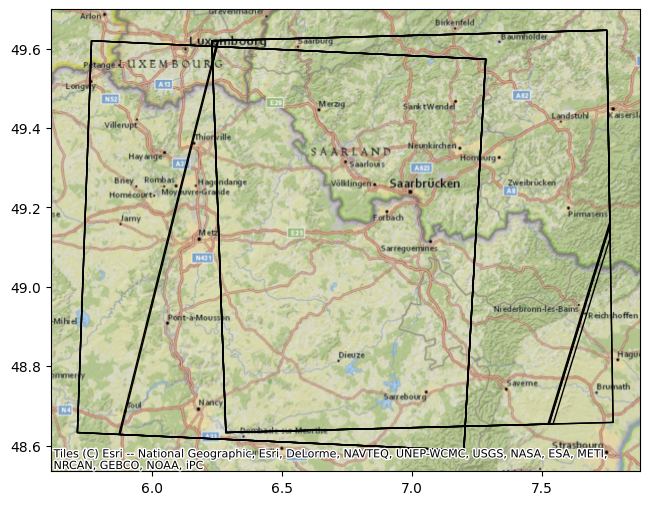

In [4]:
# Browse the S2 availability
catalog = pystac_client.Client.open("https://stac.dataspace.copernicus.eu/v1/")
time_range = "2024-04-01/2024-09-30"
bbox = [6.711273,48.998240,7.216644,49.351072]
query= {"eo:cloud_cover": {"gte": 0, "lte": 5}}
bands=["B04_10m", "B03_10m", "B02_10m"]
search = catalog.search(collections=["sentinel-2-l2a"],
                        bbox=bbox,
                        datetime=time_range,
                        query= query)
items = search.item_collection()
df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
ax = df[["geometry", "datetime",  "eo:cloud_cover"]].plot(facecolor="none", figsize=(12, 6))
contextily.add_basemap(ax, crs=df.crs.to_string(), source=contextily.providers.Esri.NatGeoWorldMap)

In [4]:
df

geometry  gsd  \
0   POLYGON ((6.23418 49.56078, 6.25713 49.62005, ...   10   
1   POLYGON ((5.87823 48.62811, 5.89331 48.66816, ...   10   
2   POLYGON ((7.76256 49.16308, 7.76184 49.16154, ...   10   
3   POLYGON ((5.76851 49.61961, 7.28505 49.57334, ...   10   
4   POLYGON ((7.76356 49.12311, 7.72666 49.0458, 7...   10   
5   POLYGON ((5.76851 49.61961, 7.28505 49.57334, ...   10   
6   POLYGON ((6.2337 49.56943, 6.25327 49.61998, 7...   10   
7   POLYGON ((5.87409 48.62823, 5.88971 48.66982, ...   10   
8   POLYGON ((7.76279 49.15413, 7.71055 49.04452, ...   10   
9   POLYGON ((5.76851 49.61961, 7.28505 49.57334, ...   10   
10  POLYGON ((7.76282 49.15285, 7.76247 49.15211, ...   10   
11  POLYGON ((5.76851 49.61961, 7.28505 49.57334, ...   10   

                        created                      updated  \
0   2024-09-20T15:55:02.000000Z  2024-09-20T20:02:35.932930Z   
1   2024-09-20T15:55:00.000000Z  2024-09-25T11:15:07.297631Z   
2   2024-08-29T15:14:47.000000Z  2024-08-29T15:38:04.210718Z   
3   2024-08-29T14:57:37.000000Z  2024-08-29T15:22:51.501385Z   
4   2024-08-24T17:52:58.000000Z  2024-08-24T18:12:58.427171Z   
5   2024-08-24T17:54:01.000000Z  2024-08-24T18:18:50.402149Z   
6   2024-08-16T15:16:36.000000Z  2024-08-16T15:35:54.919173Z   
7   2024-08-16T15:01:56.000000Z  2024-08-16T15:23:59.263813Z   
8   2024-06-25T17:49:24.000000Z  2024-06-25T18:12:05.041193Z   
9   2024-06-25T17:47:49.000000Z  2024-06-25T18:14:02.271309Z   
10  2024-05-11T13:33:45.000000Z  2024-05-11T13:50:59.229449Z   
11  2024-05-11T13:32:46.000000Z  2024-05-11T13:51:46.375359Z   

                       datetime     platform   grid:code  \
0   2024-09-20T10:27:21.025000Z  sentinel-2a  MGRS-32ULV   
1   2024-09-20T10:27:21.025000Z  sentinel-2a  MGRS-31UGQ   
2   2024-08-29T10:36:29.024000Z  sentinel-2b  MGRS-32ULV   
3   2024-08-29T10:36:29.024000Z  sentinel-2b  MGRS-31UGQ   
4   2024-08-24T10:40:21.024000Z  sentinel-2a  MGRS-32ULV   
5   2024-08-24T10:40:21.024000Z  sentinel-2a  MGRS-31UGQ   
6   2024-08-16T10:25:59.024000Z  sentinel-2b  MGRS-32ULV   
7   2024-08-16T10:25:59.024000Z  sentinel-2b  MGRS-31UGQ   
8   2024-06-25T10:36:31.024000Z  sentinel-2a  MGRS-32ULV   
9   2024-06-25T10:36:31.024000Z  sentinel-2a  MGRS-31UGQ   
10  2024-05-11T10:36:29.024000Z  sentinel-2b  MGRS-32ULV   
11  2024-05-11T10:36:29.024000Z  sentinel-2b  MGRS-31UGQ   

                      published  \
0   2024-09-20T19:55:45.836100Z   
1   2024-09-25T11:04:23.351371Z   
2   2024-08-29T15:26:43.546532Z   
3   2024-08-29T15:12:05.769863Z   
4   2024-08-24T18:03:22.734763Z   
5   2024-08-24T18:06:38.472642Z   
6   2024-08-16T15:24:40.279263Z   
7   2024-08-16T15:11:29.509560Z   
8   2024-06-25T18:04:53.218688Z   
9   2024-06-25T18:02:05.682241Z   
10  2024-05-11T13:44:15.474859Z   
11  2024-05-11T13:44:15.216715Z   

                                           statistics instruments  ...  \
0   {'water': 0.348559, 'nodata': 0.052425, 'dark_...       [msi]  ...   
1   {'water': 0.669488, 'nodata': 21.511319, 'dark...       [msi]  ...   
2   {'water': 0.3172, 'nodata': 4.412218, 'dark_ar...       [msi]  ...   
3   {'water': 0.510629, 'nodata': 0.0, 'dark_area'...       [msi]  ...   
4   {'water': 0.338406, 'nodata': 3.646056, 'dark_...       [msi]  ...   
5   {'water': 0.56311, 'nodata': 3e-06, 'dark_area...       [msi]  ...   
6   {'water': 0.340594, 'nodata': 0.058945, 'dark_...       [msi]  ...   
7   {'water': 0.652466, 'nodata': 21.603446, 'dark...       [msi]  ...   
8   {'water': 0.322984, 'nodata': 4.152883, 'dark_...       [msi]  ...   
9   {'water': 0.542898, 'nodata': 0.0, 'dark_area'...       [msi]  ...   
10  {'water': 0.384328, 'nodata': 4.238553, 'dark_...       [msi]  ...   
11  {'water': 0.629822, 'nodata': 3e-06, 'dark_are...       [msi]  ...   

   sat:absolute_orbit sat:relative_orbit view:sun_elevation  \
0               48296                108          40.586613   
1               48296                108          40.527844   
2               

In [9]:
# Download the image
zarr_store = '../dataset/s2_saar.zarr'
chunks={"x": 256, "y": 256, "time": 1}
resolution=10

kwargs_search = dict(
    bbox=bbox,
    datetime=time_range,
    query=query,
)
kwargs_load = dict(
    bbox=bbox,
    bands=bands,
    chunks=chunks,
    resolution=resolution,
    dtype="uint16",
    nodata=0)
get_S2(zarr_store, kwargs_search, kwargs_load)

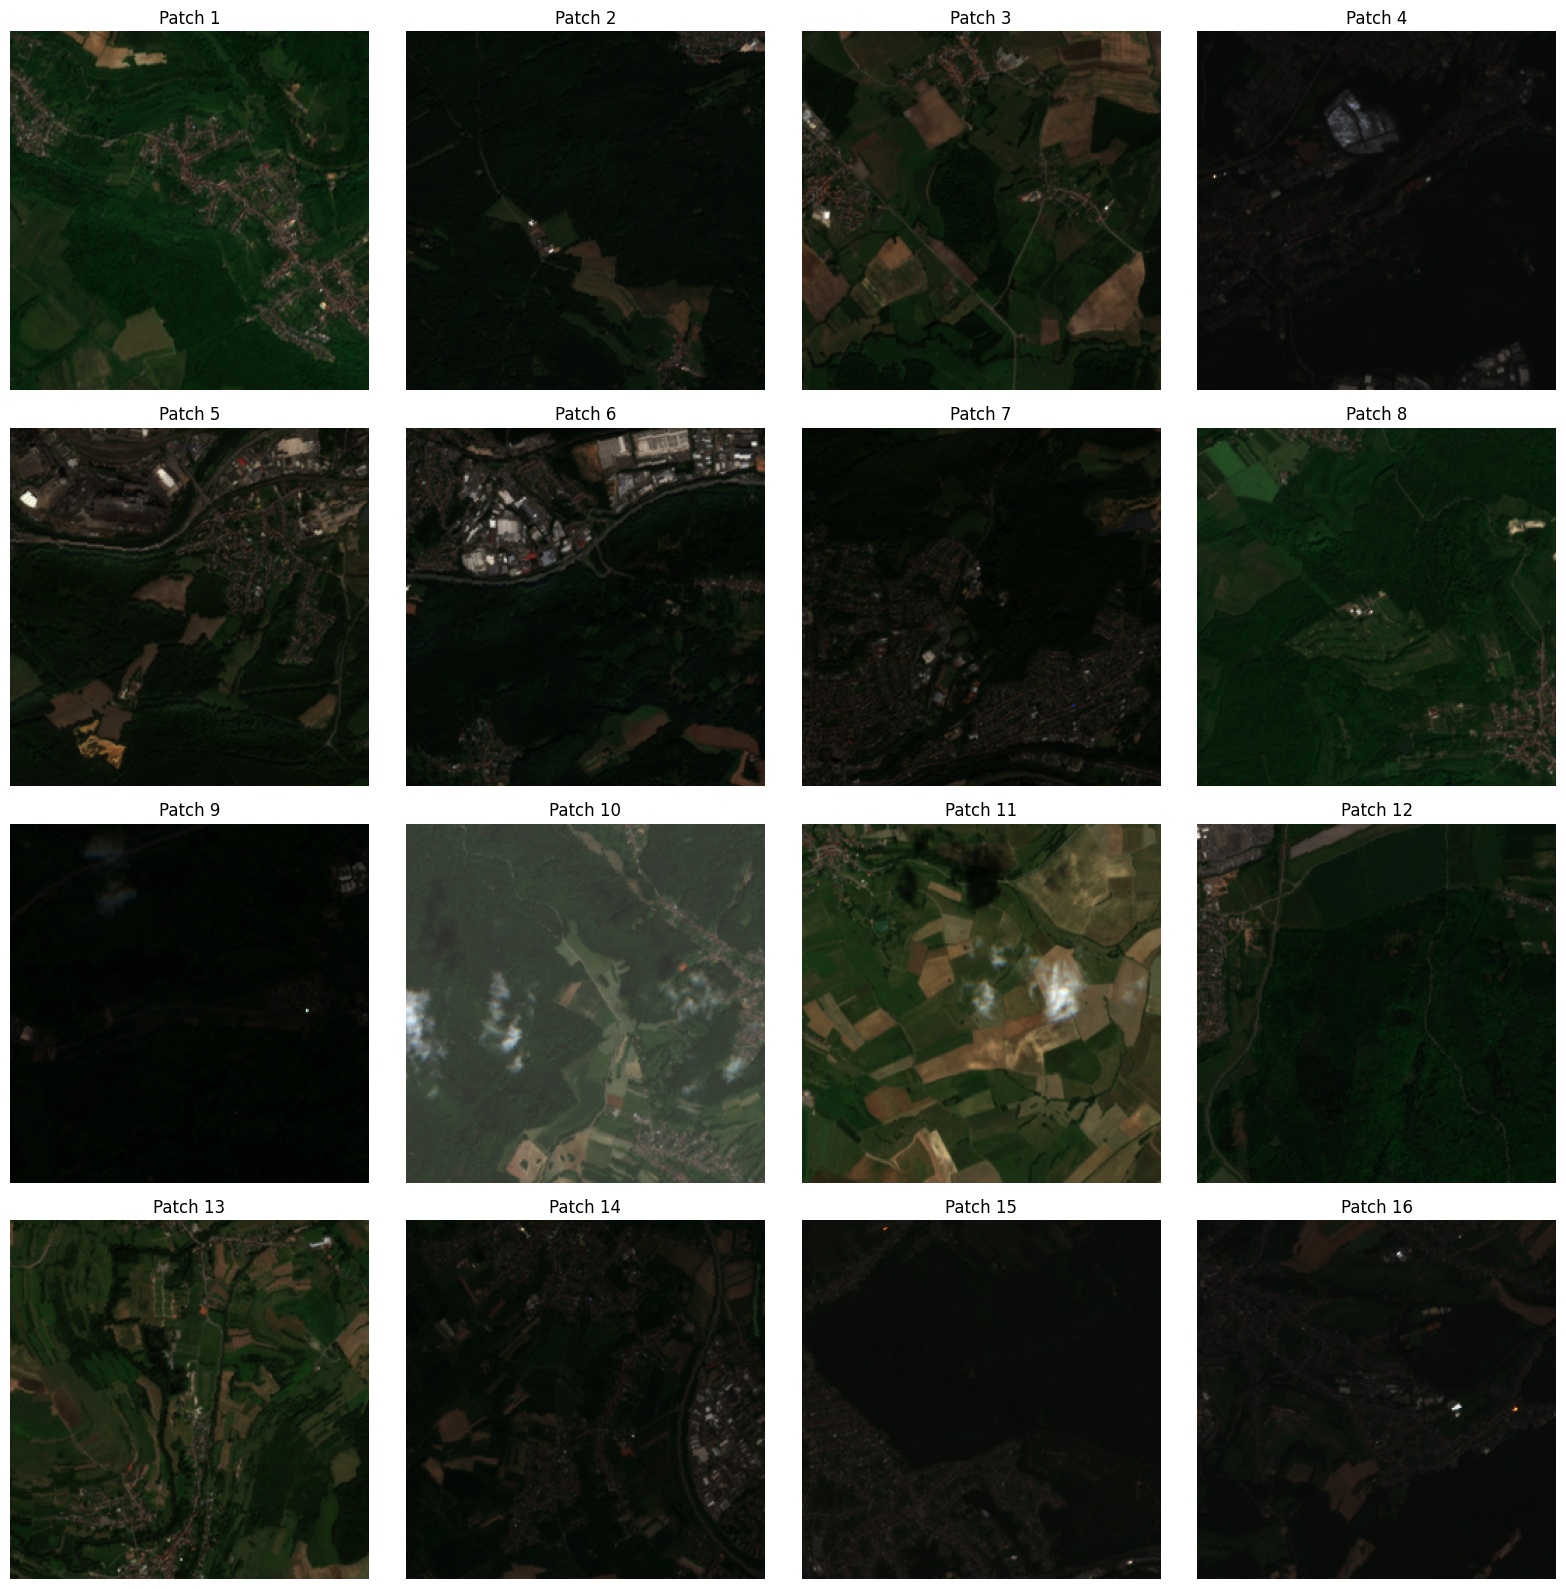

In [10]:
# Explore the zarr file
## patch level
ds = xr.open_zarr(zarr_store)

# Show a few patches to check the image
n_chunks = 16
chunk_size =  256
max_y = ds.sizes['y'] - chunk_size
max_x = ds.sizes['x'] - chunk_size

# random top-left corners for chunks
np.random.seed(30)
ys = np.random.randint(0, max_y, n_chunks)
xs = np.random.randint(0, max_x, n_chunks)
ts = np.random.randint(0, len(ds.time), n_chunks)

# prepare figure
cols = 4
rows = n_chunks//cols
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

for i, (t_idx, x_start, y_start) in enumerate(zip(ts, xs, ys)):
    r = ds['B04_10m'].isel(time=t_idx, x=slice(x_start, x_start+chunk_size), y=slice(y_start, y_start+chunk_size)).compute().values
    g = ds['B03_10m'].isel(time=t_idx, x=slice(x_start, x_start+chunk_size), y=slice(y_start, y_start+chunk_size)).compute().values
    b = ds['B02_10m'].isel(time=t_idx, x=slice(x_start, x_start+chunk_size), y=slice(y_start, y_start+chunk_size)).compute().values

    rgb = np.stack([r, g, b], axis=-1).astype(np.float32)

    # set contrast and normalisation
    rgb = exposure.rescale_intensity(rgb, in_range='image', out_range=(0, 1))

    # plot
    ax = axes.flat[i]
    ax.imshow(rgb)
    ax.set_title(f"Patch {i+1}")
    ax.axis("off")

# Hide unused axes
for j in range(i+1, len(axes.flat)):
    axes.flat[j].axis("off")

plt.tight_layout()
plt.show()


In [14]:
## Full Image
zarr_store = '../dataset/s2_saar.zarr'
ds = xr.open_zarr(zarr_store)
ds_open = xr.open_zarr(zarr_store)
ds_open = ds_open.astype('float32')
ds = ds_open[['B04_10m', 'B03_10m', 'B02_10m']]
ds = ds.rio.write_crs("EPSG:32632")

names = [t.values.astype('datetime64[D]').astype(str)[2:].replace('-', '')+ f'_{i}' for i, t in enumerate(ds.coords['time'])]
times = len(ds.coords['time'])
img_ts = [ds.isel({'time':i}) for i in range(times)]
to_tiff = [img_t.rio.to_raster(f'../dataset/{resolution}m/saar_{name}.tif',
                               driver="GTiff",
                               compress="LZW") for img_t, name in zip(img_ts, names)]

# Preprocessing dataset
1. Reduce the same date and take median
2. Normallisation using z-score

In [10]:
store = "../dataset/s2_saar.zarr"
mean_dict = {'B02_10m': 1117.2, 'B03_10m': 1041.8, 'B04_10m': 946.5}
std_dict = {'B02_10m': 736.0, 'B03_10m': 684.8, 'B04_10m': 620.0}

ds = xr.open_zarr(store).drop_vars('spatial_ref')
ds = ds[['B04_10m', 'B03_10m', 'B02_10m' ]]

# monthly reduce on time axis. reduce each month using median
ds = ds.groupby("time.month").median()
ds = ds.chunk({"x": 256, "y": 256, "month": 1}) # re-define chunk size
ds = ds.rio.write_crs("EPSG:32632", inplace=True) # ensure coordinate projection

# normalization
norm_ds = z_score_normalisation(ds, mean_dict, std_dict)

# save the images to tiff and zarr
norm_store = './dataset/s2_norm_saar.zarr'
months = len(norm_ds['month'])
names = [f'month_{month.values}' for month in norm_ds['month']]
img_ts = [norm_ds.isel({'month':i}) for i in range(months)]
to_tiff = [img_t.rio.to_raster(f'../dataset/{resolution}m/saar_norm_{name}.tif',
                               driver="GTiff",
                               compress="LZW") for img_t, name in zip(img_ts, names)]
norm_ds.to_zarr(norm_store,
                mode="w",
                consolidated=True,
                zarr_format=2)

# Setup Loader

In [7]:
ds = xr.open_zarr(norm_store)

# preparing the ds to data loader
ds['image'] = ds[bands].to_array(dim='band') # package selected band into one data variable
ds['image'].coords['band'] = ["B02", "B03", "B04"] # re-label the bands on 'image' data
ds['image'] = ds['image'].transpose('band', 'x', 'y',  'month') # reconfigure image variable shape
ds = ds.rename({'month': 'time'}) # rename the coordinate name

# Run custom dataloader
data_module = CopernicusFMDataModule(train_xr_dataset=ds['image'],
                                     input_dims={'band': 3, "x": 256, "y": 256, 'time': 1},
                                     input_overlap={"x": 0, "y": 0},
                                     batch_size_gen=8,
                                     num_workers=3)

# check the loaded data
for i, x in enumerate(data_module.train_dataloader()):
    print('iteration: ', i)
    print('shape of batch:', x.shape)
    print('percentage of invalid data: ', percentage_invalid(x))
    print()
    if i==3:
        break

iteration:  0
shape of batch: torch.Size([8, 3, 256, 256])
percentage of invalid data:  0.0

iteration:  1
shape of batch: torch.Size([8, 3, 256, 256])
percentage of invalid data:  0.0

iteration:  2
shape of batch: torch.Size([8, 3, 256, 256])
percentage of invalid data:  0.0

iteration:  3
shape of batch: torch.Size([8, 3, 256, 256])
percentage of invalid data:  0.0

